In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from cuml.metrics.cluster import silhouette_score
from cuml import DBSCAN
import time
%matplotlib inline

In [2]:
df = pd.read_csv("weather_classification_data.csv")
#drop weather type class label
labels = df['Weather Type']
df = df.drop(['Weather Type'], axis=1)
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain


In [3]:
le = LabelEncoder()
categorical = ['Cloud Cover', 'Season', 'Location']
for variable in categorical:
    df[variable] = le.fit_transform(df[variable])
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,14.0,73,9.5,82.0,3,1010.82,2,3,3.5,1
1,39.0,96,8.5,71.0,3,1011.43,7,1,10.0,1
2,30.0,64,7.0,16.0,0,1018.72,5,1,5.5,2
3,38.0,83,1.5,82.0,0,1026.25,7,1,1.0,0
4,27.0,74,17.0,66.0,2,990.67,1,3,2.5,2


In [4]:
cols = df.columns
ms = MinMaxScaler()
df = ms.fit_transform(df)
df = pd.DataFrame(df, columns=[cols])
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,0.291045,0.595506,0.195876,0.752294,1.000000,0.527951,0.142857,1.000000,0.175,0.5
1,0.477612,0.853933,0.175258,0.651376,1.000000,0.529480,0.500000,0.333333,0.500,0.5
2,0.410448,0.494382,0.144330,0.146789,0.000000,0.547746,0.357143,0.333333,0.275,1.0
3,0.470149,0.707865,0.030928,0.752294,0.000000,0.566614,0.500000,0.333333,0.050,0.0
4,0.388060,0.606742,0.350515,0.605505,0.666667,0.477461,0.071429,1.000000,0.125,1.0


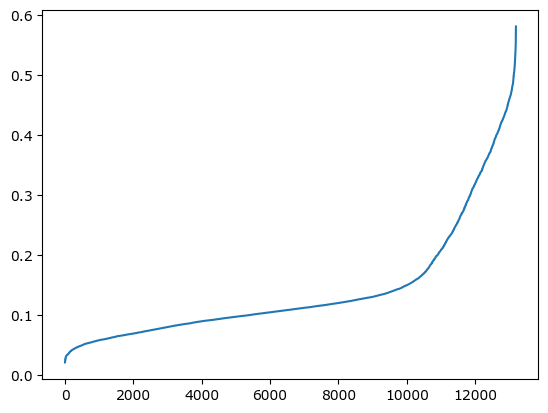

In [16]:
from cuml.neighbors import NearestNeighbors

#find a good range of epsilon using k=2*dim, then test
neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(df)
distances, indices = neighbors_fit.kneighbors(df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [5]:
# Defining the list of hyperparameters to try
eps_list=np.arange(start=0.4, stop=0.51, step=0.01)
min_sample_list=np.arange(start=11, stop=21, step=1)

# Creating empty data frame to store the silhouette scores for each trials
silhouette_scores_data=pd.DataFrame()

for eps_trial in eps_list:
    for min_sample_trial in min_sample_list:
        # Generating DBSAN clusters
        db = DBSCAN(eps=eps_trial, min_samples=min_sample_trial)
        
        if(len(np.unique(db.fit_predict(df)))>1):
            sil_score=silhouette_score(df, db.fit_predict(df))
        else:
            continue
        trial_parameters="eps:" + str(eps_trial) +" min_sample :" + str(min_sample_trial)
        
        silhouette_scores_data=pd.concat([silhouette_scores_data, pd.DataFrame(data=[[sil_score,trial_parameters]], columns=["score", "parameters"])])
    print("eps=%f done" % eps_trial)
 
# Finding out the best hyperparameters with highest Score
silhouette_scores_data.sort_values(by='score', ascending=False).head(1)

eps=0.400000 done
eps=0.410000 done
eps=0.420000 done
eps=0.430000 done
eps=0.440000 done
eps=0.450000 done
eps=0.460000 done
eps=0.470000 done
eps=0.480000 done
eps=0.490000 done
eps=0.500000 done


,score,parameters
0,0.116401,eps:0.5 min_sample :13


In [5]:
db = DBSCAN(eps=0.5, min_samples=13)
start_time = time.time()
db.fit(df)
end_time = time.time()
end_time-start_time

0.2755012512207031

In [6]:
no_clusters = len(np.unique(db.labels_))
no_noise = np.sum(np.array(db.labels_) == -1, axis=0)
if (no_clusters>2):
    no_clusters -= 1
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 3
Estimated no. of noise points: 556


In [7]:
db_label = pd.DataFrame(db.labels_, columns=['Cluster'])
df_new = pd.concat([df, db_label], axis=1)
df_new = df_new.loc[df_new['Cluster']!=-1]
df_new .info()

<class 'pandas.core.frame.DataFrame'>
Index: 12644 entries, 0 to 13199
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Temperature,)           12644 non-null  float64
 1   (Humidity,)              12644 non-null  float64
 2   (Wind Speed,)            12644 non-null  float64
 3   (Precipitation (%),)     12644 non-null  float64
 4   (Cloud Cover,)           12644 non-null  float64
 5   (Atmospheric Pressure,)  12644 non-null  float64
 6   (UV Index,)              12644 non-null  float64
 7   (Season,)                12644 non-null  float64
 8   (Visibility (km),)       12644 non-null  float64
 9   (Location,)              12644 non-null  float64
 10  Cluster                  12644 non-null  int32  
dtypes: float64(10), int32(1)
memory usage: 1.1 MB


In [8]:
#silhouette score after removing noise
df_cluster = df_new['Cluster']
df2 = df_new.drop('Cluster', axis=1)
silhouette_score(df2, df_cluster)

0.12548044446694626